In [8]:
# Author: Timothy Araujo 
# Date: Sep 12, 2023



import numpy as np
from numpy import random
import matplotlib.pyplot as plt

class AbelianSandpile:
    def __init__(self,n=100,random_state=None):
        self.n=n
        np.random.seed(random_state)
        self.grid = np.random.choice([0,1,2,3],size=(n,n))
        self.history=[self.grid.copy()]
    def not_boundary(self,x,y):
        if (x != (self.n - 1) and x != 0) and (y!=(self.n - 1) and y != 0):
            return True
        else: 
            return False
    def not_stable(self):
        for i in range(self.n):
            for j in range(self.n):
                if self.grid[i,j] >= 4:
                    return True
                else:
                    pass
        return False
    def check_corners(self,x,y):
        if (x== (self.n - 1) and y==(self.n - 1)) or (x==0 and y == (self.n - 1)) or (x == 0 and y == 0) or (x == (self.n - 1) and y == 0):
            return True
        else:
            return False
                
    def step(self):
        x = random.randint(self.n)
        y = random.randint(self.n)
        self.grid[y,x] += 1
        while self.not_stable():
            for i in range(self.n):
                for j in range(self.n):
                    if self.grid[i,j] >= 4:
                        self.grid[i,j] -= 4
                        if self.not_boundary(i,j):
                            self.grid[i+1,j] += 1
                            self.grid[i-1,j] += 1
                            self.grid[i,j+1] += 1
                            self.grid[i,j-1] += 1
                        elif self.check_corners(i,j):
                            if i == (self.n - 1) and j == (self.n - 1):
                                self.grid[i,j-1] += 1
                                self.grid[i-1,j] += 1
                            elif i == (self.n - 1) and j == 0:
                                self.grid[i-1,j] += 1
                                self.grid[i,j+1] += 1
                            elif i == 0 and j == (self.n - 1):
                                self.grid[i+1,j] += 1
                                self.grid[i,j-1] += 1
                            else:
                                self.grid[i+1,j] += 1
                                self.grid[i,j+1] += 1
                        elif (j + 1) > (self.n - 1):
                            self.grid[i+1,j] += 1
                            self.grid[i-1,j] += 1
                            self.grid[i,j-1] += 1
                        elif (j - 1) < 0:
                            self.grid[i+1,j] += 1
                            self.grid[i-1,j] += 1
                            self.grid[i,j+1] += 1
                        elif (i + 1) > (self.n - 1):
                            self.grid[i,j+1] += 1
                            self.grid[i,j-1] += 1
                            self.grid[i-1,j] += 1
                        elif (i - 1) < 0:
                            self.grid[i,j+1] += 1
                            self.grid[i+1,j] += 1
                            self.grid[i,j-1] += 1
                        else: pass
    @staticmethod
    def check_difference(grid1,grid2):
        return np.sum(grid1 != grid2)
    
    def simulate(self,n_step):
        for i in range(n_step):
            self.step()
            
            if self.check_difference(self.grid, self.history[-1]) > 0:
                self.history.append(self.grid.copy())
                
        return self.grid
    

Text(0.5, 1.0, 'Avalanche activity in most recent timesteps')

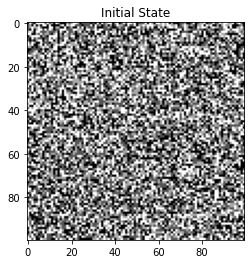

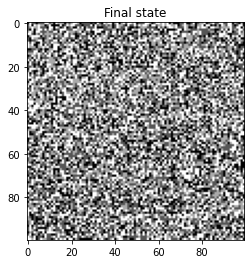

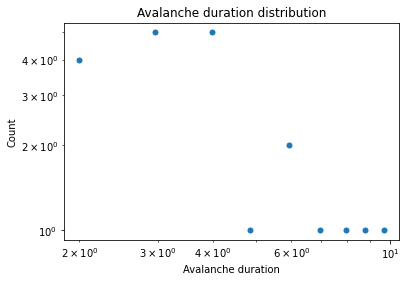

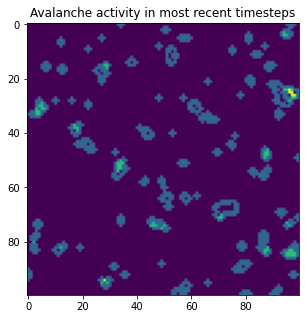

In [14]:
#from solutions.sandpile import AbelianSandpile
model = AbelianSandpile(n=100, random_state=0)
plt.figure()
plt.imshow(model.grid, cmap='gray')
plt.title("Initial State")

model.simulate(1000)
plt.figure()
plt.imshow(model.grid, cmap='gray')
plt.title("Final state")

all_events =  [model.check_difference(*states) for states in zip(model.history[:-1], model.history[1:])]
# remove transients before the self-organized critical state is reached
all_events = all_events[900:]
# index each timestep by timepoint
all_events = list(enumerate(all_events))
# remove cases where an avalanche did not occur
all_avalanches = [x for x in all_events if x[1] > 1]
all_avalanche_times = [item[0] for item in all_avalanches]
all_avalanche_sizes = [item[1] for item in all_avalanches]
all_avalanche_durations = [event1 - event0 for event0, event1 in zip(all_avalanche_times[:-1], all_avalanche_times[1:])]


log_bins = np.logspace(np.log10(2), np.log10(np.max(all_avalanche_durations)), 50) # logarithmic bins for histogram
vals, bins = np.histogram(all_avalanche_durations, bins=log_bins)
plt.figure()
plt.loglog(bins[:-1], vals, '.', markersize=10)
plt.title('Avalanche duration distribution')
plt.xlabel('Avalanche duration')
plt.ylabel('Count')

## Visualize activity of the avalanches
# Make an array storing all pairwise differences between the lattice at successive
# timepoints
all_diffs = np.abs(np.diff(np.array(model.history), axis=0))
all_diffs[all_diffs > 0] = 1
all_diffs = all_diffs[np.sum(all_diffs, axis=(1, 2)) > 1] # Filter to only keep big events
most_recent_events = np.sum(all_diffs[-100:], axis=0)
plt.figure(figsize=(5, 5))
plt.imshow(most_recent_events)
plt.title("Avalanche activity in most recent timesteps")

In [27]:
class PercolationSimulation:


    def __init__(self, n=100, p=0.5, grid=None, random_state=None):


        self.random_state = random_state # the random seed

        # Initialize a random grid if one is not provided. Otherwise, use the provided
        # grid.
        if grid is None:
            self.n = n
            self.p = p
            self.grid = np.zeros((n, n))
            self._initialize_grid()
        else:
            assert len(np.unique(np.ravel(grid))) <= 2, "Grid must only contain 0s and 1s"
            self.grid = grid.astype(int)
            # override numbers if grid is provided
            self.n = grid.shape[0]
            self.p = 1 - np.mean(grid)

        # The filled grid used in the percolation calculation. Initialize to the original
        # grid. We technically don't need to copy the original grid if we want to save
        # memory, but it makes the code easier to debug if this is a separate variable 
        # from self.grid.
        self.grid_filled = np.copy(self.grid)

    def _initialize_grid(self):
 
        np.random.seed(self.random_state)
        self.grid = np.random.choice([0,1],size=(self.n,self.n),p=[1-self.p,self.p])
        self.grid_filled = np.copy(self.grid)

    def _flow_recursive(self, i, j):

        
        if i > self.n - 1 or i < 0:
            return None
        if j > self.n - 1 or j < 0:
            return None
        
        if self.grid[i,j] == 0:
            return None
    
        if self.grid_filled[i,j] == 2:
            return None
    
        self.grid_filled[i,j] = 2
        
        self._flow_recursive(i+1,j)
        self._flow_recursive(i-1,j)
        self._flow_recursive(i,j+1)
        self._flow_recursive(i,j-1)

    def _flow(self):
        for i in range(self.n):
            self._flow_recursive(0, i)

    def percolate(self):
        self._flow()
        return np.any(self.grid_filled[-1] == 2) 



False
False
True


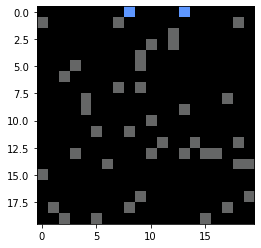

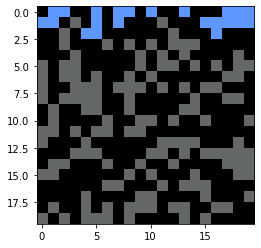

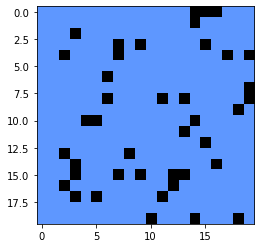

In [28]:
#from solutions.percolation import PercolationSimulation

from matplotlib.colors import LinearSegmentedColormap
def plot_percolation(mat):
    """
    Plots a percolation matrix, where 0 indicates a blocked site, 1 indicates an empty 
    site, and 2 indicates a filled site
    """
    cvals  = [0, 1, 2]
    colors = [(0, 0, 0), (0.4, 0.4, 0.4), (0.372549, 0.596078, 1)]

    norm = plt.Normalize(min(cvals), max(cvals))
    tuples = list(zip(map(norm,cvals), colors))
    cmap = LinearSegmentedColormap.from_list("", tuples)
    plt.imshow(mat, cmap=cmap, vmin=0, vmax=2)


model = PercolationSimulation(n=20, random_state=0, p=0.1)
print(model.percolate())
plt.figure()
plot_percolation(model.grid_filled)

model = PercolationSimulation(n=20, random_state=0, p=0.4)
print(model.percolate())
plt.figure()
plot_percolation(model.grid_filled)


model = PercolationSimulation(n=20, random_state=0, p=0.9)
print(model.percolate())
plt.figure()
plot_percolation(model.grid_filled)

Running replicate simulations for p = 0.0
Running replicate simulations for p = 0.041666666666666664
Running replicate simulations for p = 0.08333333333333333
Running replicate simulations for p = 0.125
Running replicate simulations for p = 0.16666666666666666
Running replicate simulations for p = 0.20833333333333331
Running replicate simulations for p = 0.25
Running replicate simulations for p = 0.29166666666666663
Running replicate simulations for p = 0.3333333333333333
Running replicate simulations for p = 0.375
Running replicate simulations for p = 0.41666666666666663
Running replicate simulations for p = 0.4583333333333333
Running replicate simulations for p = 0.5
Running replicate simulations for p = 0.5416666666666666
Running replicate simulations for p = 0.5833333333333333
Running replicate simulations for p = 0.625
Running replicate simulations for p = 0.6666666666666666
Running replicate simulations for p = 0.7083333333333333
Running replicate simulations for p = 0.75
Running

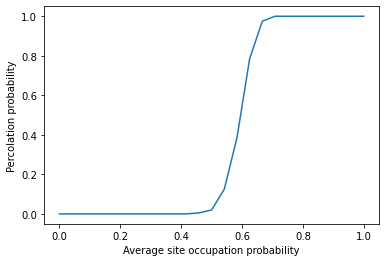

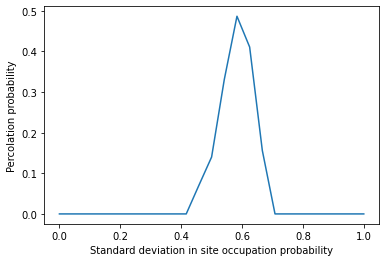

In [29]:
pvals = np.linspace(0, 1, 25) # control parameter for percolation phase transition
n_reps = 200 # number of times to repeat the simulation for each p value

all_percolations = list()
for p in pvals:
    print("Running replicate simulations for p = {}".format(p), flush=True)
    all_replicates = list()
    for i in range(n_reps):
        # Initialize the model
        model = PercolationSimulation(30, p=p)
        all_replicates.append(model.percolate())
    all_percolations.append(all_replicates)

plt.figure()
plt.plot(pvals, np.mean(np.array(all_percolations), axis=1))
plt.xlabel('Average site occupation probability')
plt.ylabel('Percolation probability')

plt.figure()
plt.plot(pvals, np.std(np.array(all_percolations), axis=1))
plt.xlabel('Standard deviation in site occupation probability')
plt.ylabel('Percolation probability')

plt.show()


Finished simulation 0
Finished simulation 500
Finished simulation 1000
Finished simulation 1500
Finished simulation 2000
Finished simulation 2500
Finished simulation 3000
Finished simulation 3500
Finished simulation 4000
Finished simulation 4500


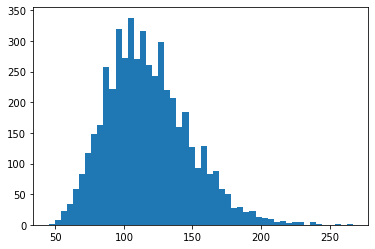

In [30]:
all_cluster_sizes = list()
p_c = 0.407259
n_reps = 5000
for i in range(n_reps):
    model = PercolationSimulation(100, p=p_c)
    model.percolate()
    cluster_size = np.sum(model.grid_filled == 2)
    all_cluster_sizes.append(cluster_size)

    if i % 500 == 0:
        print("Finished simulation {}".format(i), flush=True)

all_cluster_sizes = np.array(all_cluster_sizes)

plt.figure()
plt.hist(all_cluster_sizes, 50);
